# **Module 2: Spatial Interpolation in Python**

#### Data
For this workshop, data are created and saved to the directory `./data-module-2/`.
- `meuse.csv` -  is a data set comprising of  heavy metals measured in the top soil in a flood plain along the river Meuse (exported from `R` package `sp`).
- `meuse_grid.csv` - regular grid covering the area of interest for interpolating Meuse observations.

#### Software

To execute the code you will need a Python environment with the packages imported below. The default environment does not have all required packages to execute this script. Therefore, run the following command beforehand to install `pyinterpolate`:
- `pip install pyinterpolate --user`

To learn more about the `pyinterpolate` library:
- https://pyinterpolate.readthedocs.io/en/latest/index.html

In [ ]:
# general use packages
import os
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import math
import matplotlib.pyplot as plt

# geospatial packages
import geopandas as gpd
from shapely.geometry import MultiPoint
from shapely.ops import voronoi_diagram, triangulate
from pyinterpolate import inverse_distance_weighting
from pyinterpolate import kriging, build_experimental_variogram, TheoreticalVariogram

os.environ['PROJ_LIB'] = '/opt/conda/envs/user_default/share/proj'

### **Explore input data**

In [ ]:
meuse_df = pd.read_csv("./data-module-2/meuse.csv", index_col=0)
print ("Dataset contains {} observations".format(len(meuse_df)))
meuse_df.head()

In [ ]:
meuse_gdf = gpd.GeoDataFrame(meuse_df, geometry=gpd.points_from_xy(
    meuse_df.x, meuse_df.y), crs="epsg:28992")
meuse_gdf.head()

In [ ]:
meuse_grid_df = pd.read_csv("./data-module-2/meuse-grid.csv", index_col = 0)
meuse_grid_df.head()

In [ ]:
meuse_grid_gdf = gpd.GeoDataFrame(meuse_grid_df, geometry=gpd.points_from_xy(
    meuse_grid_df.x, meuse_grid_df.y), crs="epsg:28992")
meuse_grid_gdf.head()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), tight_layout=True)
meuse_gdf.plot(ax=axs[0], column="zinc", legend=True, cmap="YlOrBr", edgecolor="grey")
meuse_grid_gdf.plot(ax=axs[1], markersize=2, facecolor="grey", edgecolor="none")

### **Delaunay triangulation and Voronoi diagram**

Before exploring spatial interpolation from point observations to a regular grid (or a surface), we start by illustrating techniques to partition space around points to create vector surfaces.

- **Delaunay triangulation** is a technique for creating nonoverlapping triangles from a dataset of points.
- **Voronoi diagram** is constructed around each sampled point so all the space within a specific polygon is closest in distance to that sampled point (as compared to other sampled points).

In [ ]:
coordinates = MultiPoint(meuse_gdf["geometry"].tolist())

In [ ]:
delaunay_geom  = triangulate(coordinates)
delaunay_gdf = gpd.GeoDataFrame(geometry=[geom for geom in delaunay_geom], crs="epsg:28992")

In [ ]:
voronoi_geom = voronoi_diagram(coordinates)
voronoi_gdf = gpd.GeoDataFrame(geometry=[geom for geom in list(voronoi_geom.geoms)], crs="epsg:28992")

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(9, 5), tight_layout=True)

delaunay_gdf.plot(ax=axs[0], edgecolor="silver", color="beige")
meuse_gdf.plot(ax=axs[0], markersize=4, color="brown")
axs[0].set_xlim(meuse_gdf.total_bounds[0], meuse_gdf.total_bounds[2])
axs[0].set_ylim(meuse_gdf.total_bounds[1], meuse_gdf.total_bounds[3])
axs[0].set_title("Delaunay triangulation", weight="bold")

voronoi_gdf.plot(ax=axs[1], edgecolor="silver", color="beige")
meuse_gdf.plot(ax=axs[1], markersize=4, color="brown")
axs[1].set_xlim(meuse_gdf.total_bounds[0], meuse_gdf.total_bounds[2])
axs[1].set_ylim(meuse_gdf.total_bounds[1], meuse_gdf.total_bounds[3])
axs[1].set_title("Voronoi diagram", weight="bold")

### **Inverse Distance Weighting (IDW)**

#### Modeling 
IDW Parameters:
- **number of neighbours**: when using (-1), all known points will be used to estimate value at the unknown location.
- **power** controls weight assigned to each known point. Larger power means stronger influence of the closest neighbors, but it decreases quickly.


In [ ]:
known_points = meuse_df[["x", "y", "zinc"]].to_numpy()

In [ ]:
unknown_points = meuse_grid_df[["x", "y"]].to_numpy()

In [ ]:
NUMBER_OF_NEIGHBOURS = -1
IDW_POWER = 0.25

idw_predictions = []
for pt in unknown_points:
    idw_result = inverse_distance_weighting(known_points, pt, NUMBER_OF_NEIGHBOURS,  IDW_POWER)
    idw_predictions.append(idw_result)

meuse_grid_gdf["zinc-pred-{}".format(IDW_POWER)] = idw_predictions

In [ ]:
IDW_POWER = 2

idw_predictions = []
for pt in unknown_points:
    idw_result = inverse_distance_weighting(known_points, pt, NUMBER_OF_NEIGHBOURS,  IDW_POWER)
    idw_predictions.append(idw_result)

meuse_grid_gdf["zinc-pred-{}".format(IDW_POWER)] = idw_predictions

In [ ]:
IDW_POWER = 16

idw_predictions = []
for pt in unknown_points:
    idw_result = inverse_distance_weighting(known_points, pt, NUMBER_OF_NEIGHBOURS,  IDW_POWER)
    idw_predictions.append(idw_result)

meuse_grid_gdf["zinc-pred-{}".format(IDW_POWER)] = idw_predictions

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(13,5))

meuse_grid_gdf.plot(ax=axs[0], column="zinc-pred-0.25", cmap="YlOrBr", scheme="JenksCaspall", legend=True, markersize=2)
meuse_gdf.plot(ax=axs[0], edgecolor="grey", facecolor="none")
axs[0].set_title("Power=0.25", weight="bold")

meuse_grid_gdf.plot(ax=axs[1], column="zinc-pred-2", cmap="YlOrBr", scheme="JenksCaspall", legend=True, markersize=2)
meuse_gdf.plot(ax=axs[1], edgecolor="grey", facecolor="none")
axs[1].set_title("Power=2", weight="bold")

meuse_grid_gdf.plot(ax=axs[2], column="zinc-pred-16", cmap="YlOrBr", scheme="JenksCaspall", legend=True, markersize=2)
meuse_gdf.plot(ax=axs[2], edgecolor="grey", facecolor="none")
axs[2].set_title("Power=16", weight="bold")

#### Accuracy Assesment
Here we split the "known" points into a training and a test sets to evaluate model performance on real observations.

In [ ]:
np.random.seed(101)
training_set_ratio=0.5

indexes_of_training_set = np.random.choice(range(len(known_points) - 1),
                                           int(training_set_ratio * len(known_points)),
                                           replace=False)
train = known_points[indexes_of_training_set]
test = np.delete(known_points, indexes_of_training_set, 0)

In [ ]:
NUMBER_OF_NEIGHBOURS = -1
IDW_POWERS = [0.25, 2, 16]
idw_rmse = {}
r2 = {}

for pw in IDW_POWERS:
    results = []
    for pt in test:
        idw_result = inverse_distance_weighting(train, pt[:-1], NUMBER_OF_NEIGHBOURS, pw)
        results.append(idw_result)
    idw_rmse[pw] = np.sqrt(mean_squared_error(test[:, -1], results))
    r2[pw] = r2_score(test[:, -1].tolist(), results)

In [ ]:
for pw in IDW_POWERS:
    print(f'Root Mean Squared Error of prediction with IDW of power {pw} is {idw_rmse[pw]:.2f}')
    print(f'R2 with IDW of power {pw} is {r2[pw]:.2f}')

### **Krigging**

**Kriging** is a two-step process:
- It creates the variogram to estimate spatial autocorrelation. Variogram illustrates the dissimilarity between point pairs (y-axis) along a rising distance (x-axis).
- It predicts the unknown values.

#### Step 1: Build variogram

Experimental Variogram statistics:
- lag is a column with the lag center
- semivariance is a column with a dissimilarity metric
- covariance is a column with a similarity metric

In [ ]:
meuse_df["zinc"].hist(figsize=(3,2), color="tan")

In [ ]:
meuse_df["zinc-log"] = np.log(meuse_df["zinc"])
meuse_df["zinc-log"].hist(figsize=(3,2), color="tan")

In [ ]:
known_points =  meuse_df[["x", "y", "zinc-log"]].to_numpy()

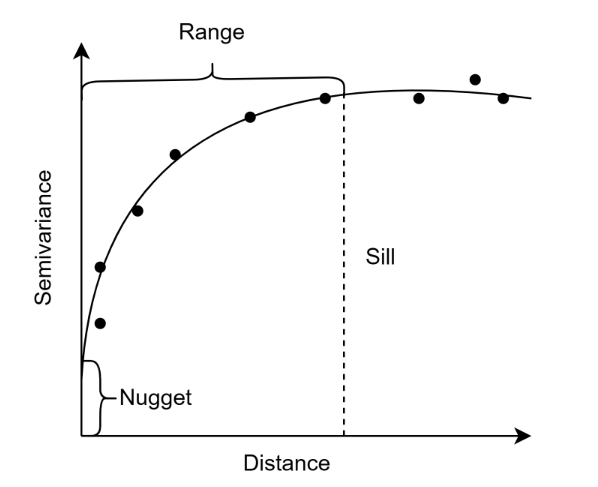

In [ ]:
STEP_SIZE = 100
MAX_RANGE = 1600

exp_semivar = build_experimental_variogram(known_points, step_size=STEP_SIZE, max_range=MAX_RANGE)

print(exp_semivar)
exp_semivar.plot()

In [ ]:
ALLOWED_MODELS = ['linear', 'circular', 'cubic', 'exponential', 'spherical']

theor_semivar = TheoreticalVariogram()
theor_semivar.autofit(experimental_variogram=exp_semivar,  model_types=ALLOWED_MODELS, max_nugget=0.8)

print (theor_semivar)
theor_semivar.plot()

#### Step 2: Make predictions

In [ ]:
predictions = kriging(observations=known_points,
                      theoretical_model=theor_semivar,
                      points=unknown_points,
                      how="ok")

In [ ]:
meuse_grid_gdf["zinc-pred-ok-krigging"] = predictions[:, 0]
meuse_grid_gdf["varience-error-ok-krigging"] = predictions[:, 1]

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(9,5))

meuse_grid_gdf.plot(ax=axs[0], column="zinc-pred-ok-krigging", cmap="YlOrBr",
                    scheme="JenksCaspall", legend=True, markersize=2)
meuse_gdf.plot(ax=axs[0], edgecolor="grey", facecolor="none")
axs[0].set_title("Ordinary Krigging Predictions (zinc-log)", weight="bold")

meuse_grid_gdf.plot(ax=axs[1], column="varience-error-ok-krigging", cmap="coolwarm",
                    scheme="JenksCaspall", legend=True, markersize=2, alpha=0.5)
meuse_gdf.plot(ax=axs[1], edgecolor="grey", facecolor="none")
axs[1].set_title("Ordinary Krigging Variance Error", weight="bold")

### **Exercises**
#### Data
For the exercies, data are created and saved to the directory `./data-module-2/`.
- `mn-dem-points.shp` -  a dataset showing sampled DEM values for Minnesota based on USGS GMTED2010 dataset.
- `mn-grid.shp` -  regular grid covering the area of interest for interpolating Minnesota DEM observations.

**Question 1. Load the datasets `mn-dem-points.csv` and `mn-grid.shp` as `GeoDataFrames`. Set CRS of for your point dataset the same as CRS of the grid shapefile.**

**Question 2. Plot the two datasets on the same `figure` object. How does Elevation vary spatially across the study area?**

**Question 3. Prepare `unknown_points` and `known_points` arrays from the datasets.**

**Question 4. Create an IDW surface predictions with different `power` parameters (`2` and `8`). Use `8` neighbous for both cases. Vizualize and compare the output (use continuous color scheme). What differences do you notice?**

**Question 5. Define a maximum range of spatial dependency for your variogram. This parameter should be at most half of the maximum distance between the known points.
Hint: use the function from: https://pyinterpolate.readthedocs.io/en/latest/api/distance/distance.html**

**Question 6. Create an experimental variogram and then use `autofit.()` to produce a theoretical model.**

**Question 7. Produce a krigging output with Oridinary Krigging method. Plot the output along with variance errors.**

### **Additional Resources**

**Alternative Python libraries:**
- https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/index.html
- https://unidata.github.io/MetPy/latest/index.html